In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.cluster import KMeans
import datetime


In [2]:
# loading the crimes data
data = pd.read_csv("Crimes_-_2001_to_present.csv")
# columns in the dataset
print(data.columns)
data.head(3)

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,4930918,HM544061,08/16/2006 03:55:00 PM,006XX W SHERIDAN RD,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,True,False,...,46.0,6.0,05,1171089.0,1926189.0,2006,02/28/2018 03:56:25 PM,41.952937,-87.646460,"(41.952937476, -87.646459694)"
1,4930924,HM545898,08/17/2006 12:00:00 AM,053XX N CUMBERLAND AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,APARTMENT,False,False,...,41.0,76.0,26,1119313.0,1934228.0,2006,02/28/2018 03:56:25 PM,41.975978,-87.836624,"(41.975978414, -87.83662354)"
2,4930927,HM545908,08/17/2006 03:00:00 PM,021XX N CANNON DR,0810,THEFT,OVER $500,OTHER,False,False,...,43.0,7.0,06,1175179.0,1914632.0,2006,02/28/2018 03:56:25 PM,41.921134,-87.631772,"(41.92113376, -87.631772431)"


In [3]:
#Removing unwanted attributes
data.drop(['X Coordinate', 'Y Coordinate', 'Updated On', 'Location', 'Beat'], axis=1, inplace=True)

In [4]:
#Data cleaning
data=data.dropna()

In [5]:
#Subsetting data for creating clusters
sub_data = data[['IUCR', 'District','Ward']]
sub_data = sub_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
sub_data['IUCR'] = sub_data.IUCR.str.extract('(\d+)', expand=True).astype(int)
sub_data.head()

,IUCR,District,Ward
0,620,19.0,46.0
1,2825,16.0,41.0
2,810,18.0,43.0
3,820,17.0,30.0
4,610,7.0,6.0


In [6]:
#Elbow method for optimal clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(sub_data)
    Sum_of_squared_distances.append(km.inertia_)

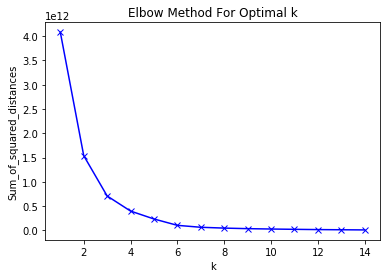

In [7]:
#plot optimal number of clusters
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [8]:
#Kmeans
km = KMeans(n_clusters=6)
km.fit(sub_data)
y = km.predict(sub_data)
labels = km.labels_
sub_data['Clusters'] = y

In [9]:
sub_data.head()

,IUCR,District,Ward,Clusters
0,620,19.0,46.0,3
1,2825,16.0,41.0,5
2,810,18.0,43.0,0
3,820,17.0,30.0,0
4,610,7.0,6.0,3


In [10]:
#attaching cluster to originla data
data['Clusters'] = y

In [11]:
#Date column
data['Date'] = pd.to_datetime(data['Date'], format = '%m/%d/%Y %I:%M:%S %p')

In [12]:
#Rerteiving Month from Date column
import calendar
data['Month'] = (data['Date'].dt.month).apply(lambda x:calendar.month_abbr[x])
data_month_dict ={
    "Jan": 1,
    "Feb": 2,
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12
}
data['Month'] = data['Month'].replace(data_month_dict)

In [13]:
#Retrieving Weekdays from Date column
data['Weekday'] = data['Date'].dt.weekday_name
data['Weekday'] = pd.Categorical(data['Weekday'],
            categories = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],ordered = True)
data_week_dict ={
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
    "Sunday": 7
}
data['Weekday'] = data['Weekday'].replace(data_week_dict)

In [14]:
#Retrieving hour form date column
data['Hour of Day'] = data['Date'].dt.hour
data['Hour of Day'] = pd.Categorical(data['Hour of Day'],
            categories = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],ordered = True)


In [16]:
data.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,Year,Latitude,Longitude,Clusters,Month,Weekday,Hour of Day
0,4930918,HM544061,2006-08-16 15:55:00,006XX W SHERIDAN RD,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,True,False,...,46.0,6.0,05,2006,41.952937,-87.646460,3,8,3,15
1,4930924,HM545898,2006-08-17 00:00:00,053XX N CUMBERLAND AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,APARTMENT,False,False,...,41.0,76.0,26,2006,41.975978,-87.836624,5,8,4,0
2,4930927,HM545908,2006-08-17 15:00:00,021XX N CANNON DR,0810,THEFT,OVER $500,OTHER,False,False,...,43.0,7.0,06,2006,41.921134,-87.631772,0,8,4,15
3,4930930,HM545922,2006-08-15 16:00:00,042XX W ROSCOE ST,0820,THEFT,$500 AND UNDER,VEHICLE NON-COMMERCIAL,False,False,...,30.0,16.0,06,2006,41.942647,-87.733798,0,8,2,16
4,4930933,HM543384,2006-08-16 10:40:00,069XX S PERRY AVE,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE PORCH/HALLWAY,False,False,...,6.0,69.0,05,2006,41.768460,-87.628248,3,8,3,10


In [17]:
#Removing unwanted attributes
data.drop(['Arrest', 'Domestic', 'FBI Code','IUCR','Description','Date','Case Number','ID','Block'], 
          axis=1, inplace=True)

In [18]:
data.head()

,Primary Type,Location Description,District,Ward,Community Area,Year,Latitude,Longitude,Clusters,Month,Weekday,Hour of Day
0,BURGLARY,APARTMENT,19.0,46.0,6.0,2006,41.952937,-87.646460,3,8,3,15
1,OTHER OFFENSE,APARTMENT,16.0,41.0,76.0,2006,41.975978,-87.836624,5,8,4,0
2,THEFT,OTHER,18.0,43.0,7.0,2006,41.921134,-87.631772,0,8,4,15
3,THEFT,VEHICLE NON-COMMERCIAL,17.0,30.0,16.0,2006,41.942647,-87.733798,0,8,2,16
4,BURGLARY,RESIDENCE PORCH/HALLWAY,7.0,6.0,69.0,2006,41.768460,-87.628248,3,8,3,10


In [21]:
#Label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["Location Description"] = le.fit_transform(data["Location Description"].astype(str))
data["Primary Type"] = le.fit_transform(data["Primary Type"])
data["Location Description"] = data["Location Description"].astype(int)

In [22]:
data.head()

,Primary Type,Location Description,District,Ward,Community Area,Year,Latitude,Longitude,Clusters,Month,Weekday,Hour of Day
0,3,17,19.0,46.0,6.0,2006,41.952937,-87.646460,3,8,3,15
1,24,17,16.0,41.0,76.0,2006,41.975978,-87.836624,5,8,4,0
2,32,122,18.0,43.0,7.0,2006,41.921134,-87.631772,0,8,4,15
3,32,170,17.0,30.0,16.0,2006,41.942647,-87.733798,0,8,2,16
4,3,138,7.0,6.0,69.0,2006,41.768460,-87.628248,3,8,3,10


In [25]:
#Data for train and test
target_col = pd.DataFrame(data['Clusters'])
data_model = data.drop(['Clusters'], axis = 1)

In [26]:
X=data_model
y=target_col

In [27]:
#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_model, target_col, test_size=0.3, random_state=42)

In [28]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
fit = log.fit(X_train,y_train)

C:\Users\renug\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\renug\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\renug\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [29]:
#metrics
from sklearn.metrics import log_loss,confusion_matrix

y_pred = log.predict(X_test)
logistic_probs = log.predict_proba(X_test)
score = log_loss(y_test, logistic_probs)
print(score)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(log.score(X_test, y_test)*100))

1.137335510665431
Accuracy of logistic regression classifier on test set: 52.23


In [31]:
#Decision tree classifier
from sklearn.tree import DecisionTreeClassifier 
decision_gini = DecisionTreeClassifier(criterion = "gini", min_samples_split=500)
decision_gini.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_pred = decision_gini.predict(X_test)
clf_probs = decision_gini.predict_proba(X_test)
score = log_loss(y_test, clf_probs)
print(score)

print ("Accuracy is ", accuracy_score(y_test,y_pred)*100)

0.050677951771650506
Accuracy is  98.39963971003168


C:\Users\renug\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Accuracy is  98.33148847506186
Log Loss: 0.08203312184889028
Classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    476966
           1       0.54      0.74      0.62     25642
           2       1.00      0.99      1.00    213230
           3       0.99      0.99      0.99    678805
           4       0.99      1.00      1.00    359499
           5       0.92      0.84      0.88     88818

   micro avg       0.98      0.98      0.98   1842960
   macro avg       0.91      0.93      0.91   1842960
weighted avg       0.99      0.98      0.98   1842960



Text(76.2,0.5,'predicted label')

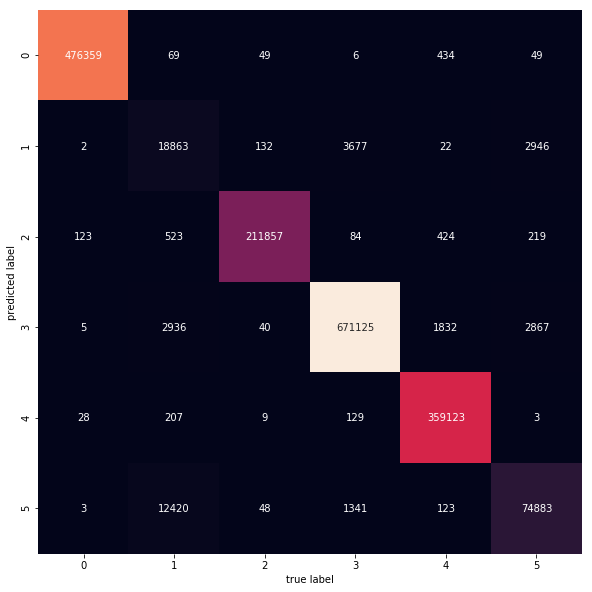

In [32]:
#Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = RandomForestClassifier(n_estimators=50, random_state=0)
#visualize_classifier(model, X, y)

model.fit(X_train, y_train)
ypred = model.predict(X_test)
print("Accuracy is ", accuracy_score(y_test,ypred)*100)

rf_probs = model.predict_proba(X_test)
score = log_loss(y_test, rf_probs)
print("Log Loss:",score)

print("Classification report:",metrics.classification_report(ypred, y_test))
plt.figure(figsize=(10,10))
mat = metrics.confusion_matrix(y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('true label')
plt.ylabel('predicted label')